# Principal Component Analysis (PCA) — From Scratch

This notebook demonstrates **Principal Component Analysis (PCA)** using the
custom implementation provided in the `rice_ml.unsupervised_learning.pca` module.

PCA is an **unsupervised dimensionality reduction technique** that projects
high-dimensional data onto a lower-dimensional subspace while preserving
as much variance as possible.

We will:
- Load The Wine Quality Dataset from a public URL
- Perform exploratory data analysis (EDA)
- Apply PCA step by step
- Visualize variance explained and 2D projections
- Interpret the results mathematically and intuitively


## Mathematical Intuition

Given a dataset represented by a feature matrix:

- Feature matrix:  
  `X ∈ ℝ^{n × d}`

PCA seeks a set of **orthonormal directions**  
`{v₁, v₂, …, v_k}` such that the projected data has **maximum variance**.

---

### Step 1: Mean Centering

Each feature is centered: X_centered = X − μ

where `μ` is the vector of feature-wise means.

---

### Step 2: Covariance Matrix

The covariance matrix is: Σ = (1 / (n − 1)) X_centeredᵀ X_centered


---

### Step 3: Eigen-Decomposition

Solve: Σ v = λ v

- `v` → principal directions (eigenvectors)
- `λ` → variance explained (eigenvalues)

---

### Step 4: Projection

Project data onto the top `k` eigenvectors: Z = X_centered V_k

This yields a lower-dimensional representation while preserving variance.










## Imports and Setup

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.unsupervised_learning.pca import PCA
from rice_ml.processing.preprocessing import standardize


## Dataset Description

The Wine Quality dataset contains physicochemical properties of red wines.
Each sample is described by 11 continuous features such as acidity, alcohol,
and sulfur dioxide concentration.

Although PCA is unsupervised, this dataset is ideal because:
- Features are numeric
- Dimensionality is moderately high
- Correlations exist between variables


In [48]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Exploratory Data Analysis

Before applying PCA, we examine:
- Feature distributions
- Scale differences
- Correlation structure

PCA is sensitive to scale, so this step is essential.

### Feature Distributions

Before applying any unsupervised learning algorithm, it is important to
understand the **marginal distributions** of each feature.

Feature distributions reveal:
- Skewness and asymmetry  
- Presence of outliers  
- Differences in scale and spread  
- Whether features are approximately Gaussian  

Because PCA is a **variance-based** method, features with large variance
can dominate the principal components if preprocessing is not handled
carefully.


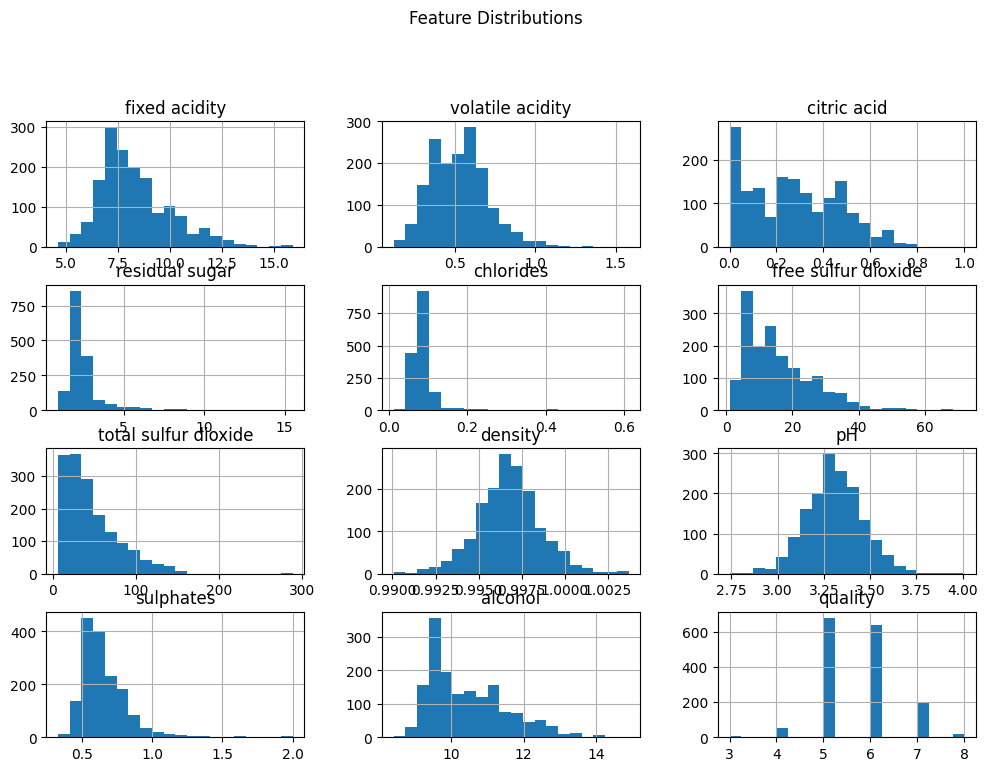

In [49]:
df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions", y=1.02)
plt.show()


### Interpretation

From the histograms, we observe that:

- Many features exhibit **right skew** rather than symmetric distributions  
- Some features have **long tails**, indicating potential outliers  
- The spread (variance) differs significantly across features  

These observations are important because:
- PCA does not assume normality, but extreme skew and outliers can
  disproportionately influence variance
- Features with larger numeric ranges may dominate principal components
  unless standardized

This motivates the use of **feature standardization** before PCA.


### Feature Scale Comparison

Next, we compare feature scales directly using box plots.

This visualization highlights:
- Differences in magnitude across features  
- Relative variance and interquartile range  
- Outliers across dimensions  

Because PCA relies on the covariance matrix, which is sensitive to scale,
features measured on larger numeric ranges can overwhelm smaller-scale
features if left unscaled.


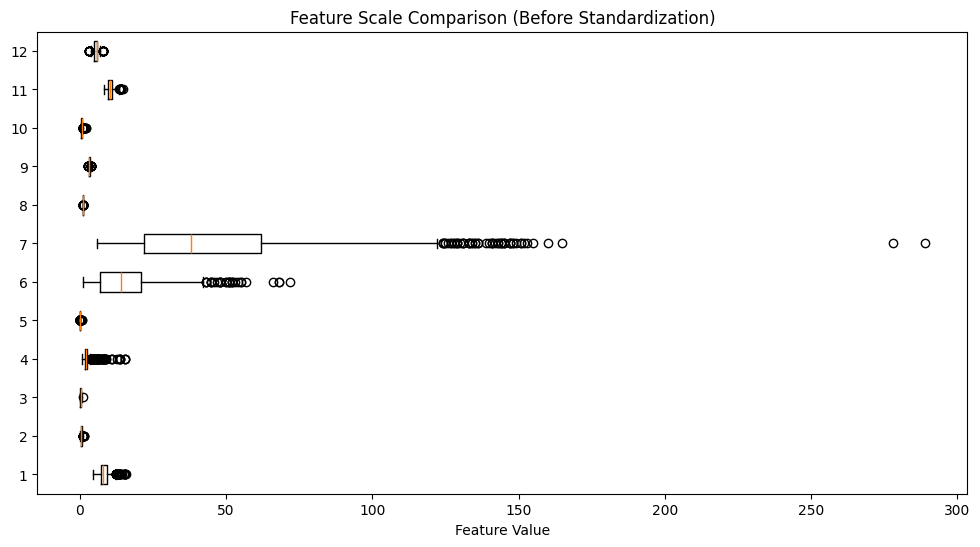

In [50]:
plt.figure(figsize=(12, 6))
plt.boxplot(df.values, vert=False)
plt.title("Feature Scale Comparison (Before Standardization)")
plt.xlabel("Feature Value")
plt.show()


### Interpretation

From the box plots, we see that:

- Some features span very wide numeric ranges
- Others are tightly concentrated around small values
- Several features contain notable outliers

Without preprocessing:
- High-variance features would dominate PCA directions
- Principal components would reflect **units of measurement**, not structure

To ensure that PCA captures **relationships among variables rather than
raw scale**, we standardize each feature to zero mean and unit variance.


### Correlation Structure

Although PCA does **not require labels**, it is strongly influenced by
**correlations among features**.

Highly correlated variables indicate redundancy:
- PCA can compress these into fewer dimensions
- Strong correlations often lead to large eigenvalues
- Uncorrelated features contribute less to shared variance

We visualize the **pairwise Pearson correlation matrix** to understand
which features move together and how much redundancy exists in the data.


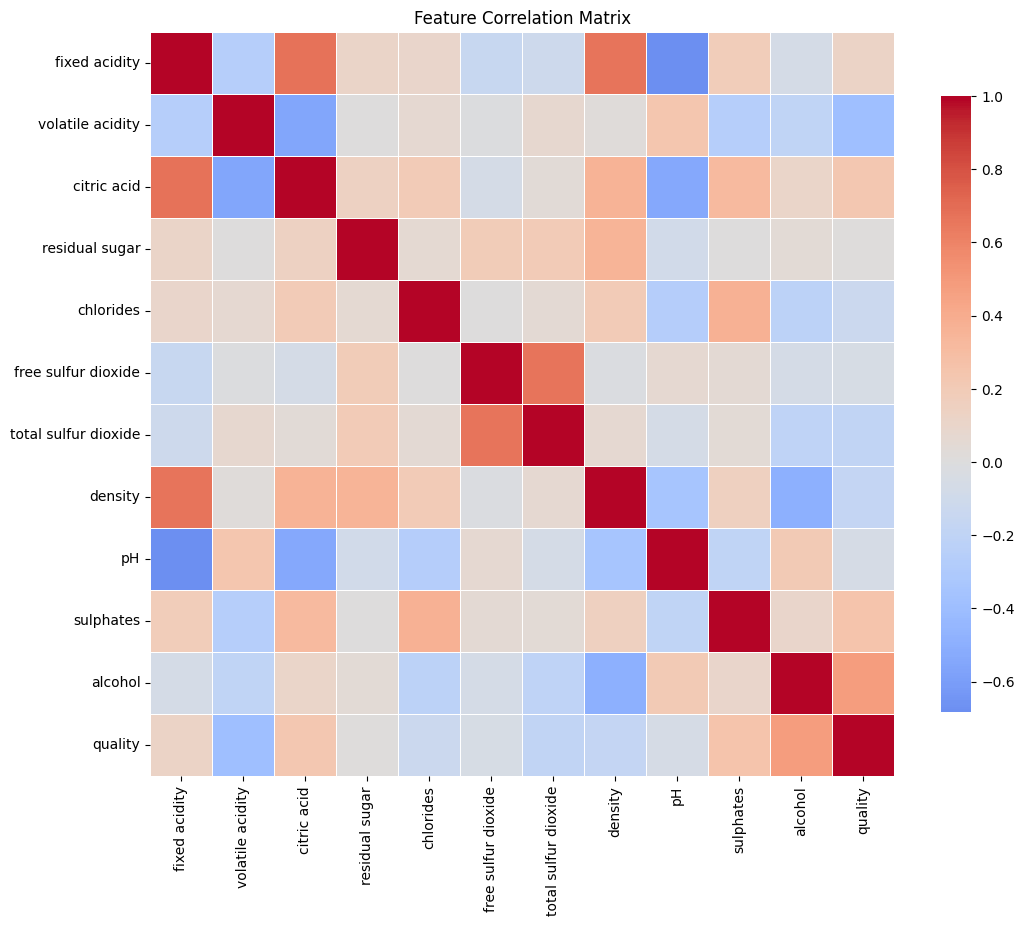

In [51]:
import seaborn as sns

corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Matrix")
plt.show()


### Interpretation

Key observations from the correlation matrix:

- Strong positive or negative correlations indicate **shared variance**
- Groups of correlated features suggest **lower intrinsic dimensionality**
- PCA will tend to align its first components along these correlated directions

For example:
- If two chemical measurements are highly correlated,
  PCA can represent them with a single principal component.
- Weakly correlated features contribute to later components.

This explains *why PCA works* — it exploits correlation to compress data
without significant information loss.


## Preprocessing

### Why Standardization?

PCA is based on variance.
Features with larger scales dominate the covariance matrix.

We standardize features as: X_std = (X − μ) / σ

This ensures:
- Equal contribution of all features
- Numerically stable covariance estimation
- Meaningful principal components


In [52]:
X = df.values
X_std = standardize(X)

## Applying Principal Component Analysis (PCA)

After preprocessing and exploratory data analysis, we apply
**Principal Component Analysis (PCA)** to reduce the dimensionality
of the dataset while preserving as much variance as possible.

PCA is an **unsupervised** technique, meaning:
- It does not use labels
- It relies solely on the structure of the feature space
- It identifies latent directions of maximal variance

Mathematically, PCA finds orthogonal directions  
$w_1, w_2, \dots$ that solve:

$$
\max_{w} \ \mathrm{Var}(Xw)
\quad \text{subject to } \|w\| = 1
$$

Each principal component corresponds to an eigenvector of the
covariance matrix of the standardized data.


In [53]:
# Number of features
n_features = X_std.shape[1]

# Fit PCA with all components
pca_full = PCA(n_components=n_features)
X_pca_full = pca_full.fit_transform(X_std)


## Explained Variance

Each principal component explains a certain amount of the total
variance in the data.

Let:
- $\lambda_k$ be the eigenvalue associated with component $k$
- $\sum_j \lambda_j$ be the total variance across all components

Then the **explained variance ratio** for component $k$ is:

$$
\mathrm{Explained\ Variance\ Ratio}_k =
\frac{\lambda_k}{\sum_j \lambda_j}
$$

This quantity measures how much information is retained when we
keep that component.


In [54]:
print("Explained Variance:", pca_full.explained_variance_)
print("Explained Variance Ratio:", pca_full.explained_variance_ratio_)
print("Total Explained Variance:", pca_full.explained_variance_ratio_.sum())


Explained Variance: [3.12312087 2.24328497 1.68397283 1.21578121 0.97387267 0.66300688
 0.61870473 0.50618912 0.41156493 0.3281246  0.18033141 0.05955516]
Explained Variance Ratio: [0.26009731 0.1868235  0.14024331 0.10125174 0.0811053  0.05521602
 0.05152648 0.04215605 0.03427563 0.02732662 0.01501822 0.00495983]
Total Explained Variance: 1.0000000000000002


### Interpretation

Key observations from the explained variance ratios:

- The first few components explain a **large fraction** of total variance
- Later components contribute progressively less information
- Variance is often concentrated in a small number of directions

This indicates that:
- The data lies near a lower-dimensional subspace
- Many original features are correlated or redundant
- Dimensionality reduction is appropriate without severe information loss


## Scree Plot Analysis

A scree plot displays the explained variance ratio as a function
of the component index.

It is commonly used to:
- Identify diminishing returns in additional components
- Select a reasonable cutoff for dimensionality reduction
- Visualize the intrinsic dimensionality of the data



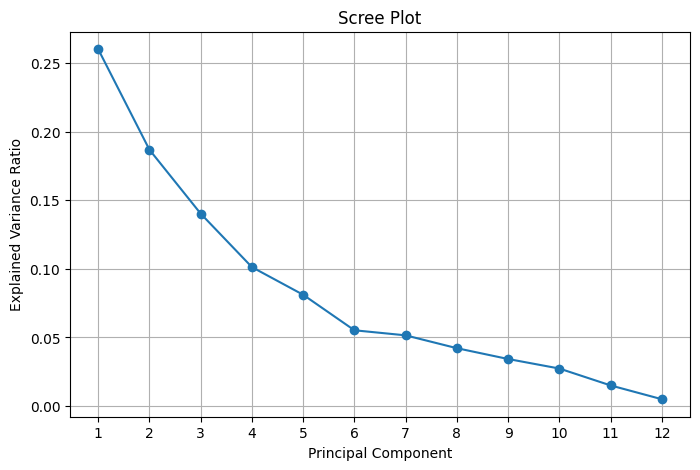

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Explained variance ratios
explained_var = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, n_features + 1),
    explained_var,
    marker="o"
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.xticks(np.arange(1, n_features + 1))
plt.grid(True)
plt.show()


### Scree Plot Interpretation

From the scree plot, we observe:

- A sharp drop in explained variance for the first few components
- A gradual flattening of the curve afterward
- An "elbow point" where additional components add minimal information

This elbow suggests:
- The effective dimensionality of the dataset
- A natural trade-off between complexity and information retention

Keeping components beyond this point yields little benefit while
increasing model complexity and noise.


## Cumulative Explained Variance

This helps decide how many components are needed to retain a desired amount of variance (e.g., 90–95%).

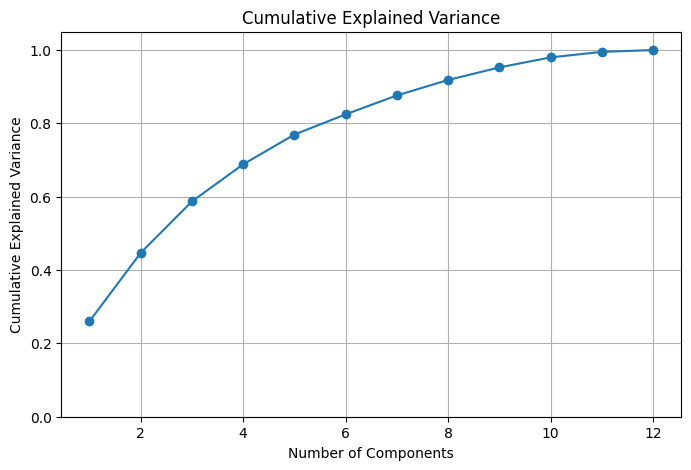

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, n_features + 1),
    np.cumsum(explained_var),
    marker="o"
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


## Choosing the Number of Components

In practice, the number of principal components can be chosen by:

- Retaining a fixed percentage of variance (e.g., 90–95%)
- Identifying the elbow point in the scree plot
- Selecting a dimensionality suitable for visualization (e.g., 2D)

Next, we retain a small number of components to:
- Visualize the data structure
- Preserve most of the informative variance
- Maintain interpretability


In [57]:
# Fit PCA with 2 components
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

## 2D PCA Projection

To visualize the high-dimensional dataset, we project the data onto
the first two principal components:

$$
Z = X_{\text{std}} \, W_{1:2}
$$

where:
- $X_{\text{std}}$ is the standardized data
- $W_{1:2}$ contains the first two principal axes (principal directions)

This produces a 2D representation that captures the largest sources
of variation in the data.


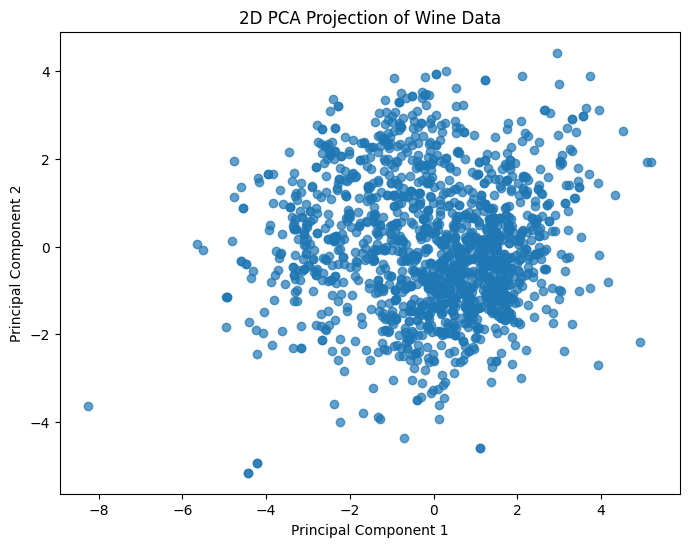

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Projection of Wine Data")
plt.show()


## Interpretation

- **PC1** captures the direction of maximum variance
- **PC2** captures the largest remaining variance orthogonal to PC1
- PCA axes are linear combinations of original features

### No Clear Clusters

The lack of sharply separated groups suggests:

The wine data does not naturally separate into distinct clusters in the first two components

Any class structure (e.g., wine quality labels) is likely not linearly separable in low dimensions

### Important caveats:
- PCA preserves variance, not class separation
- Overlapping clusters may still be separable in higher dimensions
- Linear projections cannot capture nonlinear structure

Nevertheless, the projection provides valuable intuition about
the geometry and organization of the data.


## Inverse Transform

We can approximately reconstruct the original data:

X_reconstructed = Z Vᵀ + μ

This allows us to measure information loss.


In [59]:
X_reconstructed = pca.inverse_transform(X_pca)

reconstruction_error = np.mean((X_std - X_reconstructed) ** 2)
print("Reconstruction Error:", reconstruction_error)

Reconstruction Error: 0.5530791882930832


### Interpretation:

Reconstruction error > 0

Measures information lost by dimensionality reduction

## When to Use PCA

PCA is useful for:
- Visualization of high-dimensional data
- Noise reduction
- Preprocessing for clustering or classification
- Mitigating multicollinearity

PCA should NOT be used when:
- Feature interpretability is critical
- Data is categorical or non-linear


## Limitations of PCA

While PCA is powerful, it has important limitations:

- Only captures **linear** relationships
- Sensitive to outliers
- Maximizes variance, not predictive performance
- Components may be difficult to interpret individually

Despite these limitations, PCA is an essential tool for:
- Visualization
- Noise reduction
- Preprocessing for downstream models


## Conclusion

In this notebook, we implemented and applied **Principal Component Analysis**
from scratch using the `rice_ml` package.

We demonstrated:
- Mathematical foundations of PCA
- Importance of standardization
- Dimensionality reduction and visualization
- Variance preservation and reconstruction

PCA serves as a powerful unsupervised learning tool and is a foundational
technique for clustering, visualization, and preprocessing in modern
machine learning pipelines.
